In [1]:
# Instala librerías necesarias
!pip install torch


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

## Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,10,10,10,10,1] en grilla 20x20, con optimizador Adam y activación Tanh al igual que el caso original.

### 0 - Sin agregar mejoras: 

Epoch 0, Loss: 0.47677478194236755
Epoch 100, Loss: 0.06626258045434952
Epoch 200, Loss: 0.028150249272584915
Epoch 300, Loss: 0.00653778575360775
Epoch 400, Loss: 0.004645894281566143
Epoch 500, Loss: 0.003766605630517006
Epoch 600, Loss: 0.003364469390362501
Epoch 700, Loss: 0.0030752040911465883
Epoch 800, Loss: 0.0027965488843619823
Epoch 900, Loss: 0.0025094072334468365
Epoch 1000, Loss: 0.002214031759649515
Epoch 1100, Loss: 0.0019199945963919163
Epoch 1200, Loss: 0.0016423976048827171
Epoch 1300, Loss: 0.0013934843009337783
Epoch 1400, Loss: 0.0011790702119469643
Epoch 1500, Loss: 0.0010020285844802856
Epoch 1600, Loss: 0.0008632850367575884
Epoch 1700, Loss: 0.0007598521769978106
Epoch 1800, Loss: 0.0006845752941444516
Epoch 1900, Loss: 0.0006287610740400851
Epoch 2000, Loss: 0.0005848892033100128
Epoch 2100, Loss: 0.0005476545775309205
Epoch 2200, Loss: 0.0005138638662174344
Epoch 2300, Loss: 0.00048194779083132744
Epoch 2400, Loss: 0.0004514403408393264
Epoch 2500, Loss: 0.00

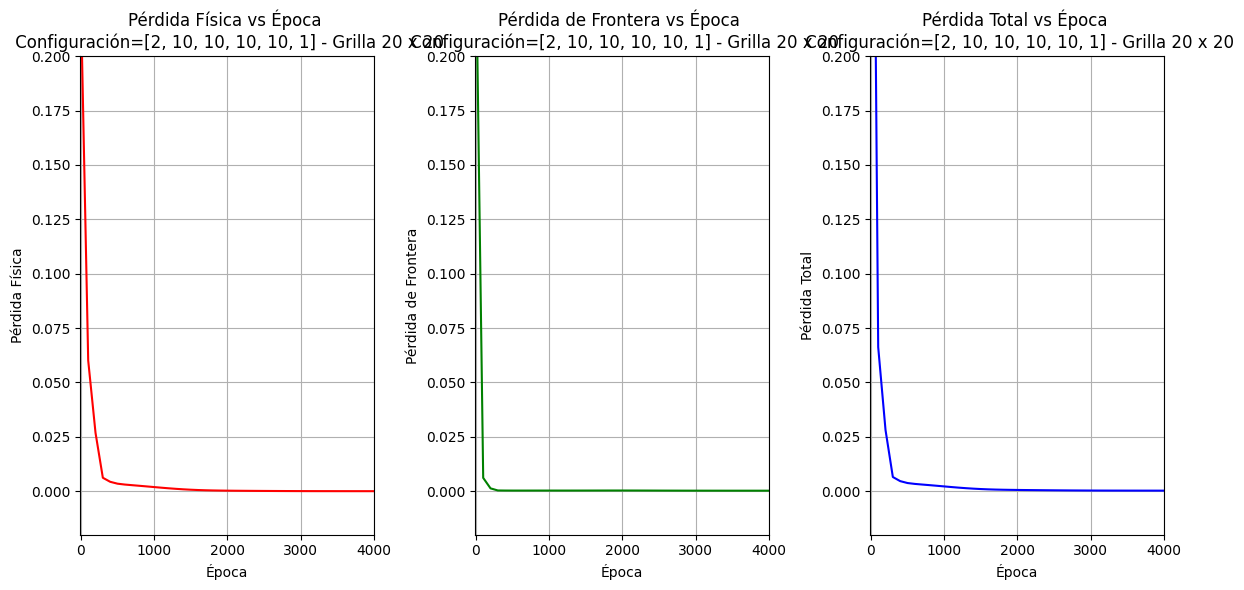

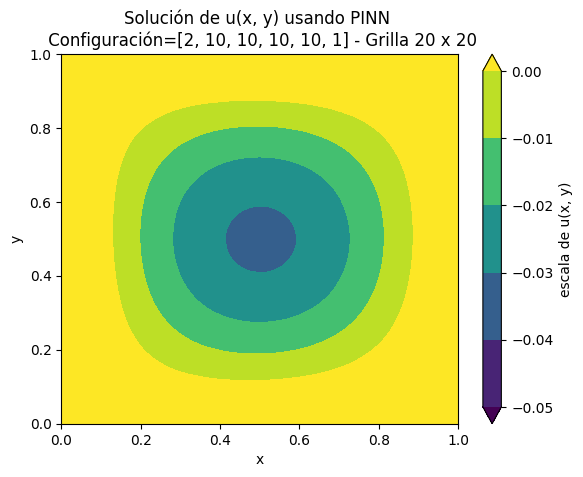

In [ ]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)    # Entrada
        self.fc2 = nn.Linear(10, 10)   # Capa oculta 1
        self.fc3 = nn.Linear(10, 10)   # Capa oculta 2
        self.fc4 = nn.Linear(10, 10)   # Capa oculta 3
        self.fc5 = nn.Linear(10, 1)    # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 10, 10, 1] \n Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 10, 10, 1] \n Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 10, 10, 1] \n Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\3261108849.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\3261108849.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

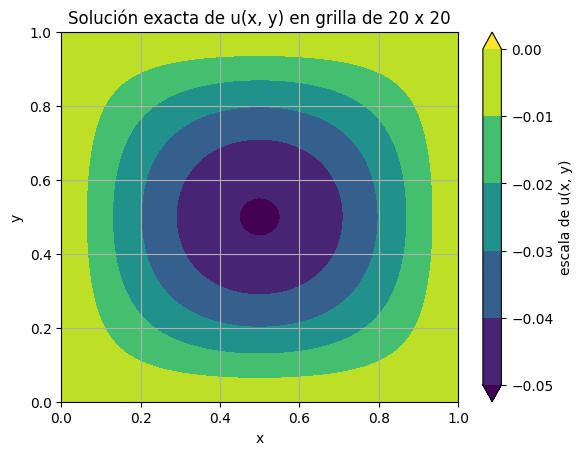

In [5]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\2436640092.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\2436640092.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

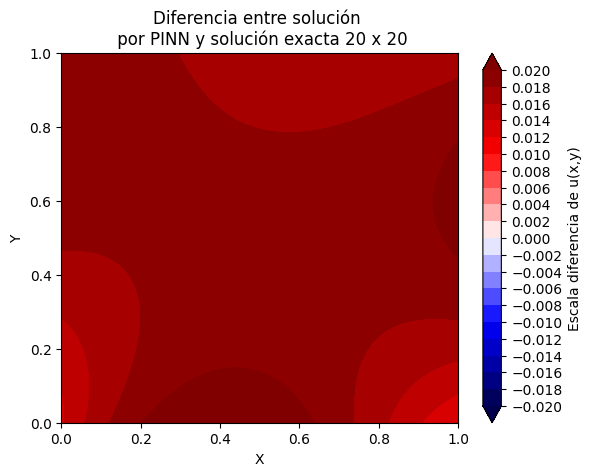

In [6]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

### I - Agregando implementación “hard” de CB Dirichlet:

Epoch 0, Loss: 0.43542706966400146
Epoch 100, Loss: 0.030376257374882698
Epoch 200, Loss: 0.02979719452559948
Epoch 300, Loss: 0.028996486216783524
Epoch 400, Loss: 0.02725490741431713
Epoch 500, Loss: 0.022523190826177597
Epoch 600, Loss: 0.008045757189393044
Epoch 700, Loss: 0.0007738636923022568
Epoch 800, Loss: 0.00035740435123443604
Epoch 900, Loss: 0.0002634207485243678
Epoch 1000, Loss: 0.0002021903492277488
Epoch 1100, Loss: 0.0001594395434949547
Epoch 1200, Loss: 0.00012853351654484868
Epoch 1300, Loss: 0.0001056391847669147
Epoch 1400, Loss: 8.833913307171315e-05
Epoch 1500, Loss: 7.503524102503434e-05
Epoch 1600, Loss: 6.46386033622548e-05
Epoch 1700, Loss: 5.638971924781799e-05
Epoch 1800, Loss: 4.9749036406865343e-05
Epoch 1900, Loss: 4.4326428906060755e-05
Epoch 2000, Loss: 3.9836257201386616e-05
Epoch 2100, Loss: 3.606653626775369e-05
Epoch 2200, Loss: 3.285894126747735e-05
Epoch 2300, Loss: 3.0094286557869054e-05
Epoch 2400, Loss: 2.7682301151799038e-05
Epoch 2500, Loss

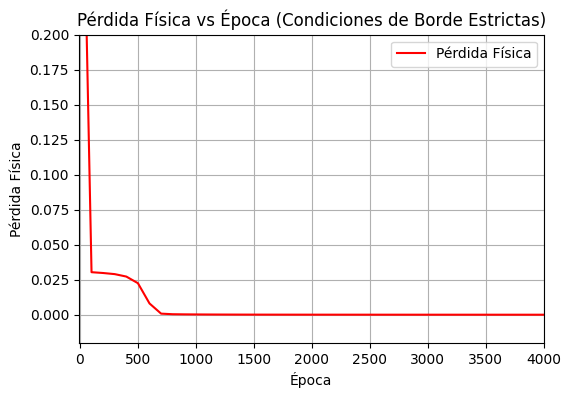

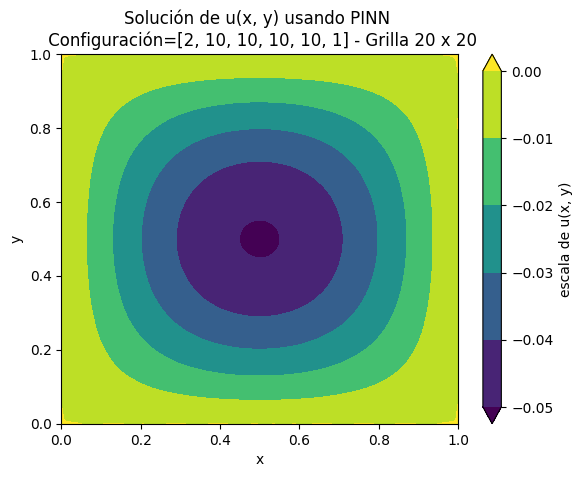

In [20]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 10)  # Capa oculta 2
        self.fc4 = nn.Linear(10, 10)  # Capa oculta 3
        self.fc5 = nn.Linear(10, 1)  # Salida

    def forward(self, x, y):
        # Concatena x y para pasar como entrada
        xy = torch.cat((x, y), dim=1)
        # Red neuronal feedforward con activaciones tanh
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

# Modifica la salida para cumplir con condiciones de borde
class PINNWithBoundary(PINN):
    def forward(self, x, y):
        # Define la salida de la red neuronal base
        u_hat = super().forward(x, y)
        # Implementa las condiciones de borde estrictamente
        u = (1 - x) * x * (1 - y) * y * u_hat  # Cumple con u(x=0, y)=u(x=1, y)=u(x, y=0)=u(x, y=1)=0
        return u

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)

        # Optimización
        loss_physics.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            print(f"Epoch {epoch}, Loss: {loss_physics.item()}")

    return model, loss_physics_list

# Definir los puntos de colocación (malla 20x20) fuera de la función de entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Inicializa la red neuronal y el optimizador
model = PINNWithBoundary()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrena el modelo
trained_model, loss_physics_list = train(model, optimizer, x, y)

# Grafica la pérdida física
epochs = np.arange(0, 10000, 100)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época (Condiciones de Borde Estrictas)')
plt.grid(True)
plt.legend()
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.show()

# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\3261108849.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\3261108849.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

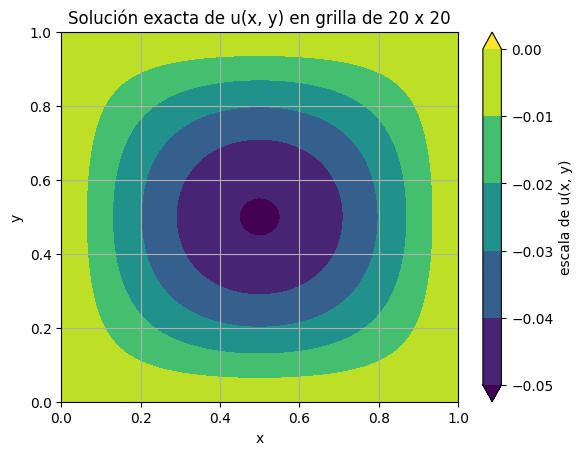

In [21]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\1928789233.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\1928789233.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

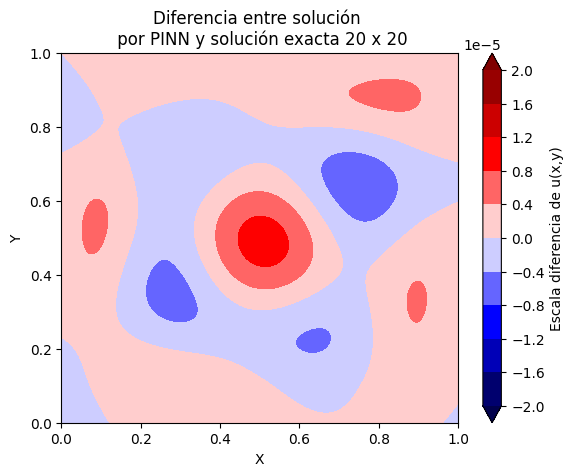

In [25]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.000020, -0.000016, -0.000012, -0.000008, -0.000004, 0.000000, 0.000004, 0.000008, 0.000012, 0.000016, 0.000020], vmin=-0.000020, vmax=0.000020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.000020, -0.000016, -0.000012, -0.000008, -0.000004, 0.000000, 0.000004, 0.000008, 0.000012, 0.000016, 0.000020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

### II - Igual al anterior, pero agregando Adimensionalización por dominio espacial.

Epoch 0, Loss: 467.29437255859375
Epoch 100, Loss: 0.08979122340679169
Epoch 200, Loss: 0.07719555497169495
Epoch 300, Loss: 0.07500331103801727
Epoch 400, Loss: 0.07249316573143005
Epoch 500, Loss: 0.06975866854190826
Epoch 600, Loss: 0.06686981767416
Epoch 700, Loss: 0.06387969851493835
Epoch 800, Loss: 0.060828521847724915
Epoch 900, Loss: 0.057747021317481995
Epoch 1000, Loss: 0.0546574741601944
Epoch 1100, Loss: 0.051576461642980576
Epoch 1200, Loss: 0.04851523041725159
Epoch 1300, Loss: 0.045481882989406586
Epoch 1400, Loss: 0.042481616139411926
Epoch 1500, Loss: 0.03951839357614517
Epoch 1600, Loss: 0.03659478574991226
Epoch 1700, Loss: 0.03371328487992287
Epoch 1800, Loss: 0.03087671287357807
Epoch 1900, Loss: 0.028088588267564774
Epoch 2000, Loss: 0.025353310629725456
Epoch 2100, Loss: 0.022676698863506317
Epoch 2200, Loss: 0.020065968856215477
Epoch 2300, Loss: 0.017530513927340508
Epoch 2400, Loss: 0.015082749538123608
Epoch 2500, Loss: 0.012740127742290497
Epoch 2600, Loss:

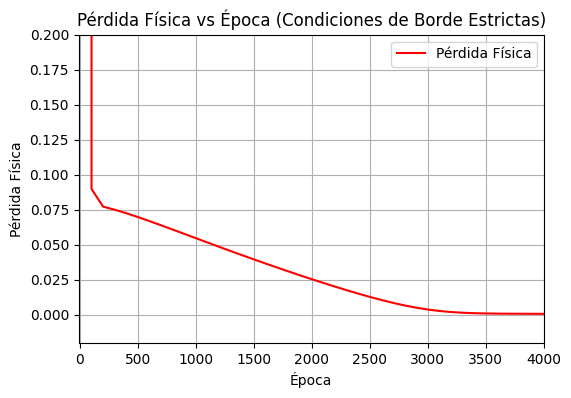

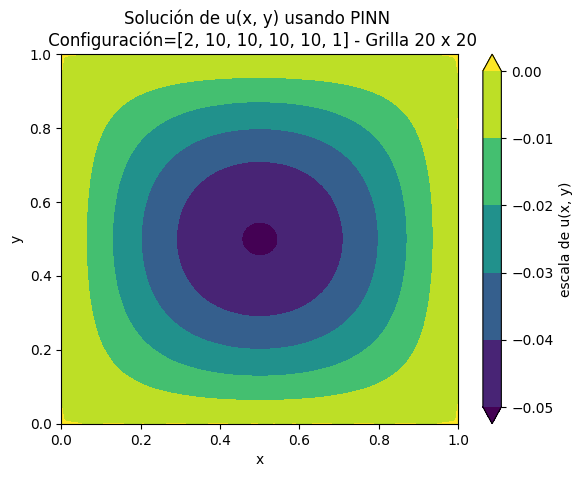

In [26]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 10)  # Capa oculta 2
        self.fc4 = nn.Linear(10, 10)  # Capa oculta 3
        self.fc5 = nn.Linear(10, 1)  # Salida

    def forward(self, x, y):
        # Concatena x y para pasar como entrada
        xy = torch.cat((x, y), dim=1)
        # Red neuronal feedforward con activaciones tanh
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

# Modifica la salida para cumplir con condiciones de borde
class PINNWithBoundary(PINN):
    def __init__(self):
        super(PINNWithBoundary, self).__init__()

        # U_ref es una constante de referencia para la adimensionalización de u
        self.U_ref = 0.01  # valor arbitrario (órden de magnitud de la solución) como constante de referencia

    def forward(self, x, y):
        # Obtiene la salida de la red neuronal (u_hat)
        u_hat = super().forward(x, y)

        # Adimensionaliza la salida de la red neuronal
        u_star = u_hat / self.U_ref

        # Implementa las condiciones de frontera estrictas sobre la salida adimensionalizada
        u_star = (1 - x) * x * (1 - y) * y * u_star  # Cumple con u(x=0, y)=u(x=1, y)=u(x, y=0)=u(x, y=1)=0
        
        return u_star

# Define la ecuación de la física (adimensionalizada)
def physics_loss(x, y, model):
    u_star = model(x, y)

    # Derivadas parciales de u* respecto a x e y
    u_x = torch.autograd.grad(u_star, x, grad_outputs=torch.ones_like(u_star), create_graph=True)[0]
    u_y = torch.autograd.grad(u_star, y, grad_outputs=torch.ones_like(u_star), create_graph=True)[0]

    # Derivadas segundas de u* respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u*
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial en forma adimensionalizada
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Función de entrenamiento
def train(model, optimizer, x_train, y_train, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x_train, y_train, model)

        # Optimización
        loss_physics.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            print(f"Epoch {epoch}, Loss: {loss_physics.item()}")

    return model, loss_physics_list

# Definir puntos de colocación fuera del ciclo de entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x_train = x.flatten().reshape(-1, 1)
y_train = y.flatten().reshape(-1, 1)

# Inicializa la red neuronal y el optimizador
model = PINNWithBoundary()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrena el modelo
trained_model, loss_physics_list = train(model, optimizer, x_train, y_train)

# Grafica la pérdida física
epochs = np.arange(0, 10000, 100)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época (Condiciones de Borde Estrictas)')
plt.grid(True)
plt.legend()
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.show()

# Evalua el modelo en la malla definida
# Aplanar x y y, y concatenarlos en la dimensión correcta
x_flat = x.flatten().reshape(-1, 1)
y_flat = y.flatten().reshape(-1, 1)

# Concatenar x y y
input_tensor = torch.cat((x_flat, y_flat), dim=1)

# Evaluar el modelo
u_pred_20x20 = trained_model(input_tensor[:, 0:1], input_tensor[:, 1:2]).detach().numpy()

# Redimensionar la salida a la grilla 20x20
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\3261108849.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\3261108849.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

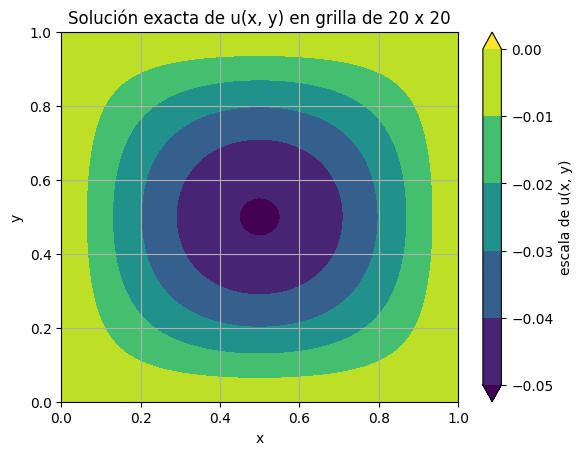

In [27]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\4276412403.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_8396\4276412403.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

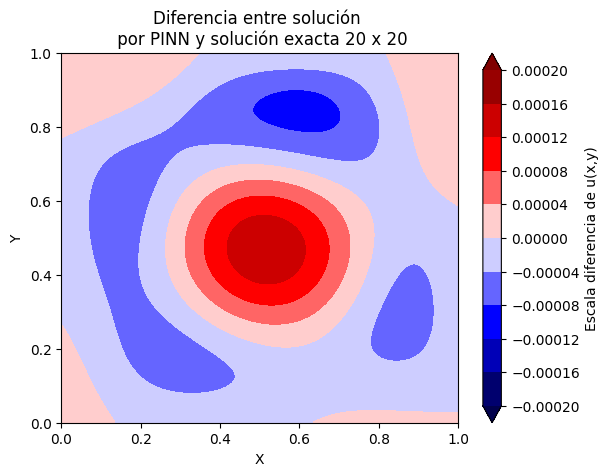

In [29]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.00020, -0.00016, -0.00012, -0.00008, -0.00004, 0.00000, 0.00004, 0.00008, 0.00012, 0.00016, 0.00020], vmin=-0.00020, vmax=0.00020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.00020, -0.00016, -0.00012, -0.00008, -0.00004, 0.00000, 0.00004, 0.00008, 0.00012, 0.00016, 0.00020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20